# Recommending movies using Truncated SVD

\- [Saurabh Mathur](saurabhmathur96.github.io)

In this experiment, I factorize the user x movie matrix and reconstruct it from the first 10 components. The reconstructed matrix represents some latent features that are correlated with the user ratings and can be used for predicting the rating.

Thus, using Truncated SVD movies can be recommended.

In [1]:
import pandas as pd

movies = pd.read_csv("../data/intermediate/movies.csv", index_col=0)

movies.head()

,MovieID,Title,Genres,ContinuousMovieID
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [2]:
import scipy.io

R = scipy.io.mmread("../data/intermediate/user_movie_ratings.mtx").tocsr()


print ('{0}x{1} user by movie matrix'.format(*R.shape))

6040x3883 user by movie matrix


## Perform Truncated SVD on Ratings matrix

In [3]:
from sklearn.decomposition import TruncatedSVD

train = R[:4000, :3000]
test = R[4000:, 3000:]

movie_svd = TruncatedSVD(n_components=10)
movie_features = movie_svd.fit_transform(train.T)

print ("movie_features.shape = {0}".format(movie_features.shape))


user_svd = TruncatedSVD(n_components=10)
user_features = user_svd.fit_transform(train)

print ("user_features.shape = {0}".format(user_features.shape))

movie_features.shape = (3000, 10)
user_features.shape = (4000, 10)


## TSNE Visualization

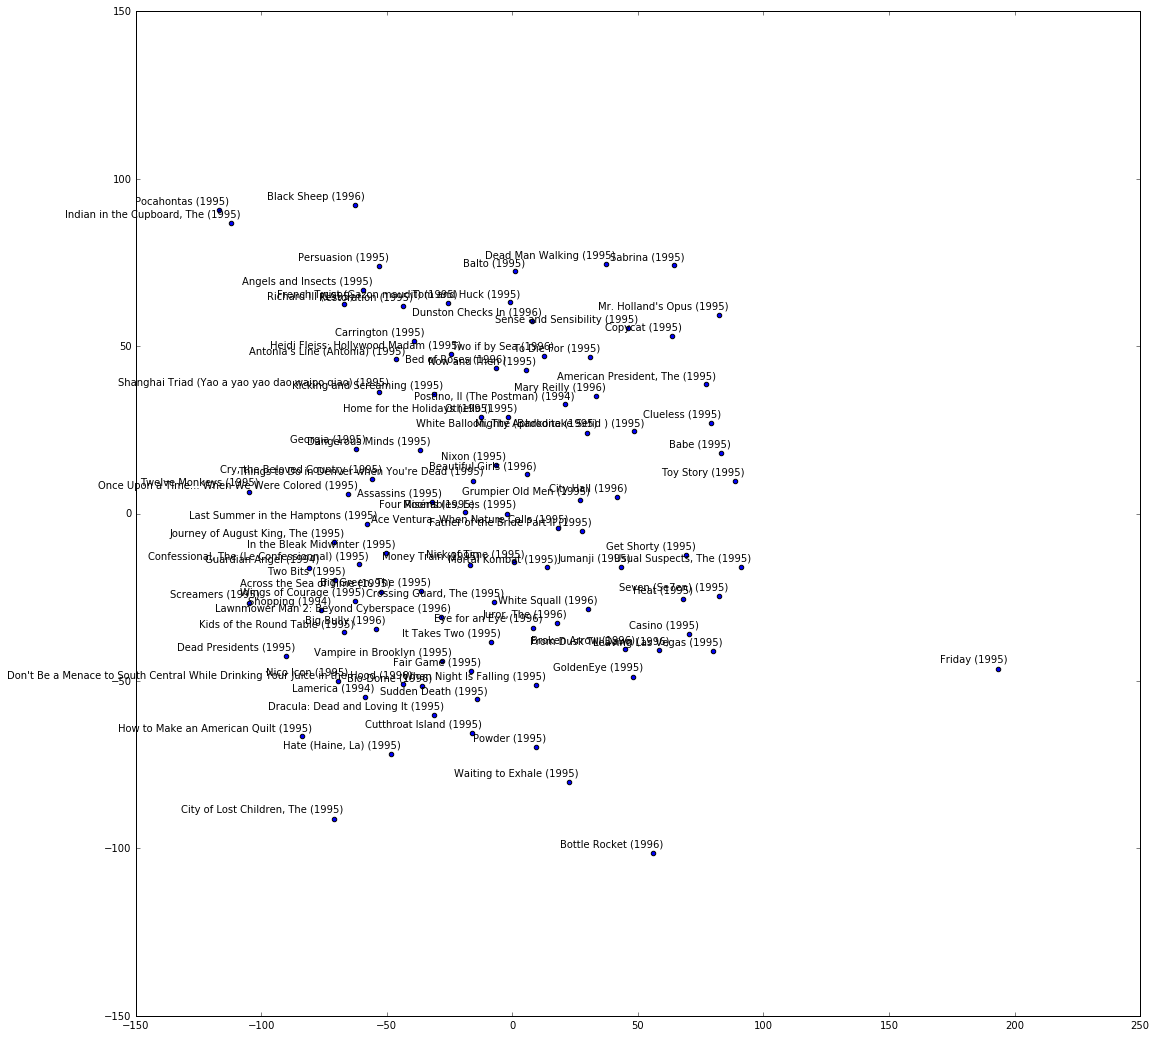

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(perplexity=15, n_components=2, init="pca", n_iter=5000)
plot_only = 100
coords = tsne.fit_transform(movie_features[:plot_only, :])

plt.figure(figsize=(18, 18))
labels = [movies.iloc[i].Title.decode("latin_1") for i in range(plot_only)]
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 4),
                 textcoords="offset points",
                 ha="right",
                 va="bottom")

plt.show()

In [6]:
pd.DataFrame(dict(highest = movies.loc[movie_features.argmax(axis=0)].Title.tolist(),
                  lowest = movies.loc[movie_features.argmin(axis=0)].Title.tolist()))

,highest,lowest
0,Star Wars: Episode IV - A New Hope (1977),Guardian Angel (1994)
1,Annie Hall (1977),Independence Day (ID4) (1996)
2,Star Wars: Episode IV - A New Hope (1977),Good Will Hunting (1997)
3,American Beauty (1999),Mary Poppins (1964)
4,Shakespeare in Love (1998),Heat (1995)
5,Clerks (1994),Saving Private Ryan (1998)
6,Ferris Bueller's Day Off (1986),Beauty and the Beast (1991)
7,"Sixth Sense, The (1999)",Star Trek: First Contact (1996)
8,E.T. the Extra-Terrestrial (1982),Some Like It Hot (1959)
9,Shakespeare in Love (1998),"Lion King, The (1994)"


In [7]:
ratings = pd.read_csv("../data/intermediate/ratings.csv", index_col=0)

ratings.head()

,UserID,ContinuousUserID,MovieID,ContinuousMovieID,Rating
0,1,0,1,0,5
1,1,0,48,47,5
2,1,0,150,148,5
3,1,0,260,257,4
4,1,0,527,523,5


In [8]:
columns = ["uf{0}".format(i+1) for i in range(10)]
ufs = pd.DataFrame(user_features, columns = columns)
ufs["ContinuousUserID"] = ufs.index
print ("len(ufs) = {0}".format(len(ufs)))

columns = ["mf{0}".format(i+1) for i in range(10)]
mfs = pd.DataFrame(movie_features, columns = columns)
mfs["ContinuousMovieID"] = mfs.index
print ("len(ufs) = {0}".format(len(ufs)))

train_data = ratings.merge(ufs, on="ContinuousUserID") \
    .merge(mfs, on="ContinuousMovieID") \
    .drop(["UserID", "ContinuousUserID", "MovieID", "ContinuousMovieID"], axis = 1)

print ("len(train_data) = {0}".format(len(train_data)))

len(ufs) = 4000
len(ufs) = 4000
len(train_data) = 542783


In [9]:
import numpy as np

targets = np.array(train_data.Rating)
data = np.array(train_data.drop("Rating", axis = 1))

print ("targets.shape = {0}".format(targets.shape))
print ("data.shape = {0}".format(data.shape))

targets.shape = (542783,)
data.shape = (542783, 20)


## Training a Gradient Boosted Regressor on latent features

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 
import math

regressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, verbose=1)
regressor.fit(data, targets)

print (math.sqrt(mean_squared_error( regressor.predict(data), targets )))

      Iter       Train Loss   Remaining Time 
         1           1.2233            5.38m
         2           1.1893            6.07m
         3           1.1603            5.85m
         4           1.1374            5.57m
         5           1.1172            5.38m
         6           1.1018            5.41m
         7           1.0873            5.60m
         8           1.0755            5.51m
         9           1.0651            5.40m
        10           1.0573            5.30m
        20           1.0109            4.83m
        30           0.9922            4.76m
        40           0.9801            4.42m
        50           0.9702            4.07m
        60           0.9621            3.72m
        70           0.9556            3.41m
        80           0.9497            3.12m
        90           0.9445            2.89m
       100           0.9393            2.64m
       200           0.9059            0.00s
0.951779741472


In [11]:
print (math.sqrt(mean_squared_error( regressor.predict(data), targets )))

0.951779741472
